# Makemore Part 5

> Building a WaveNet

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
# read in all the words
words = open('../names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
  
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e


In [ ]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
  
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
  
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
  
    def parameters(self):
        return [self.gamma, self.beta]
# -----------------------------------------------------------------------------------------------
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [ ]:
torch.manual_seed(42); # seed rng for reproducibility

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
C = torch.randn((vocab_size, n_embd)) # embedding table
layers = [Linear(n_embd*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
          Linear(n_hidden, vocab_size)
         ]

# parameter init
with torch.no_grad():
    layers[-1].weight *= 0.1 # last layer make less confident at initialization

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12097


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
#     break

      0/ 200000: 3.2966
  10000/ 200000: 2.2322
  20000/ 200000: 2.4111
  30000/ 200000: 2.1004
  40000/ 200000: 2.3157
  50000/ 200000: 2.2104
  60000/ 200000: 1.9653
  70000/ 200000: 1.9767
  80000/ 200000: 2.6738
  90000/ 200000: 2.0837
 100000/ 200000: 2.2730
 110000/ 200000: 1.7491
 120000/ 200000: 2.2891
 130000/ 200000: 2.3443
 140000/ 200000: 2.1731
 150000/ 200000: 1.8246
 160000/ 200000: 1.7614
 170000/ 200000: 2.2419
 180000/ 200000: 2.0803
 190000/ 200000: 2.1326


[<matplotlib.lines.Line2D>]

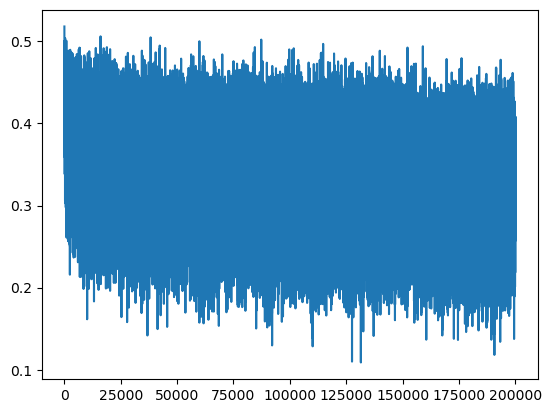

In [ ]:
plt.plot(lossi)

In [ ]:
lossi[:10]

[0.5180676579475403,
 0.5164594054222107,
 0.507362961769104,
 0.507546603679657,
 0.4992470443248749,
 0.5014019012451172,
 0.5049523115158081,
 0.48866209387779236,
 0.4999050199985504,
 0.4899313449859619]

The above plot was a "dagger in the eyes". There is a lot of variability in loss from one batch to the next (because of our relatively small batch size of 32 training examples). Let's do a plot where we visualize the loss like so:

In [ ]:
torch.tensor(lossi).view(-1,1000).shape

torch.Size([200, 1000])

[<matplotlib.lines.Line2D>]

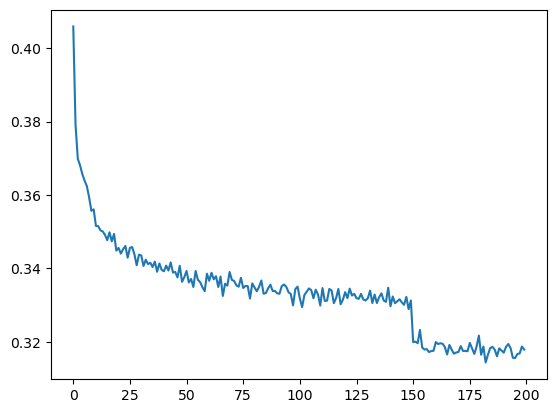

In [ ]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [ ]:
# put layers into eval mode (needed for batchnorm especially)
for layer in layers:
    layer.training = False

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0583250522613525
val 2.1065289974212646


In [ ]:
for _ in range(20):
    out=[]
    context = [0]*block_size
    while True:
        emb = C[torch.tensor([context])]
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:]+[ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join([itos[i] for i in out]))

ivon.
fanili.
thoommara.
kelo.
matyn.
leandr.
aleigh.
koldeniah.
prus.
carleen.
jah.
jorra.
alaya.
shonan.
vishylaharia.
juna.
vio.
orven.
mina.
laylee.


## Introduce Embedding and Flatten

In [ ]:
# -----------------------------------------------------------------------------------------------
class Embedding:
  
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
  
    def parameters(self):
        return [self.weight]

# -----------------------------------------------------------------------------------------------
class Flatten:
    
    def __call__(self,x):
        self.out = x.view(x.shape[0],-1)
        return self.out
    
    def parameters(self):
        return []

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

layers = [Embedding(vocab_size, n_embd),
          Flatten(),
          Linear(n_embd*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
          Linear(n_hidden, vocab_size)
         ]

# parameter init
with torch.no_grad():
    layers[-1].weight *= 0.1 # last layer make less confident at initialization

parameters = [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12097


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    x = Xb
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 3.2877


## Introduce Sequential

In [ ]:
# -----------------------------------------------------------------------------------------------
class Sequential:
  
    def __init__(self, layers):
        self.layers = layers
  
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
  
    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
# Stop: 04/14/2023 13m22s/56m21s

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

model = Sequential([Embedding(vocab_size, n_embd),
                    Flatten(),
                    Linear(n_embd*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
                    Linear(n_hidden, vocab_size)
                    ]
                   )

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # last layer make less confident at initialization

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12097


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
#     break

      0/ 200000: 3.2951
  10000/ 200000: 2.4608
  20000/ 200000: 1.9612
  30000/ 200000: 2.2665
  40000/ 200000: 2.0159
  50000/ 200000: 2.6640
  60000/ 200000: 2.0771
  70000/ 200000: 2.2932
  80000/ 200000: 2.4355
  90000/ 200000: 2.3301
 100000/ 200000: 2.2692
 110000/ 200000: 2.2957
 120000/ 200000: 2.3526
 130000/ 200000: 2.0627
 140000/ 200000: 2.5461
 150000/ 200000: 1.8184
 160000/ 200000: 2.1374
 170000/ 200000: 2.3346
 180000/ 200000: 2.0952
 190000/ 200000: 1.6799


[<matplotlib.lines.Line2D>]

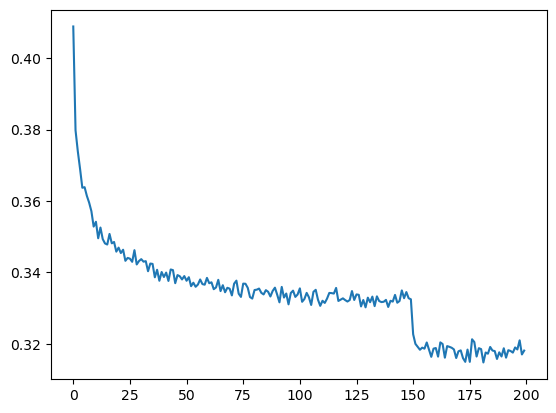

In [ ]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [ ]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0593814849853516
val 2.104369640350342


In [ ]:
for _ in range(20):
    out=[]
    context = [0]*block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:]+[ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join([itos[i] for i in out]))

foralrabhithaan.
man.
reema.
ana.
deanyell.
tedaryia.
saove.
adise.
madie.
kasuka.
lakileanni.
shaadora.
zhan.
evre.
rae.
stevin.
el.
kamelian.
kamelynny.
dalucki.


## Naive scale up

By updating the block Size

In [ ]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
  
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [ ]:
for x, y in zip(Xtr[:20],Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

model = Sequential([Embedding(vocab_size, n_embd),
                    Flatten(),
                    Linear(n_embd*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
                    Linear(n_hidden, vocab_size)
                    ]
                   )

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # last layer make less confident at initialization

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

22097


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
#     break

      0/ 200000: 3.2832
  10000/ 200000: 2.4753
  20000/ 200000: 2.1789
  30000/ 200000: 1.8599
  40000/ 200000: 2.2194
  50000/ 200000: 2.6839
  60000/ 200000: 2.1948
  70000/ 200000: 2.2742
  80000/ 200000: 2.1448
  90000/ 200000: 1.8690
 100000/ 200000: 2.0104
 110000/ 200000: 1.6630
 120000/ 200000: 2.0151
 130000/ 200000: 1.8984
 140000/ 200000: 1.9967
 150000/ 200000: 2.0680
 160000/ 200000: 1.8812
 170000/ 200000: 2.2087
 180000/ 200000: 1.5459
 190000/ 200000: 1.5059


[<matplotlib.lines.Line2D>]

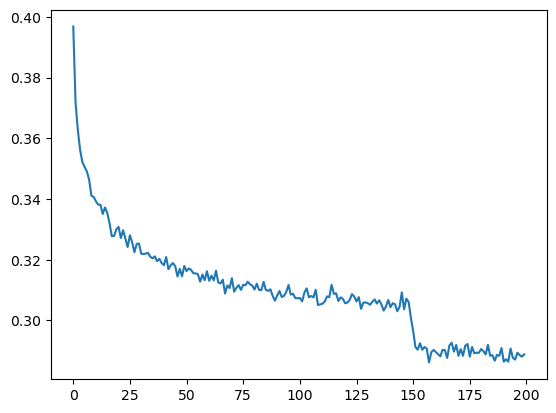

In [ ]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [ ]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.918139100074768
val 2.0279526710510254


In [ ]:
for _ in range(20):
    out=[]
    context = [0]*block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:]+[ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join([itos[i] for i in out]))

macin.
avyren.
solamor.
taerie.
bribith.
salif.
maagraca.
daveri.
jaden.
leyannah.
kion.
katzia.
rhyon.
sylver.
gavena.
theona.
zackir.
bevelo.
kiairos.
kandon.


## Scratch Space

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

model = Sequential([Embedding(vocab_size, n_embd),
                    Flatten(),
                    Linear(n_embd*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
                    Linear(n_hidden, vocab_size)
                    ]
                   )

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # last layer make less confident at initialization

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

22097


In [ ]:
ix = torch.randint(0,Xtr.shape[0],(4,)) # Let's look at a batch of just 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb) # logits aka logcounts
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0, 10,  1,  9,  4,  5],
        [ 0,  0,  0,  0,  0,  0,  0,  3],
        [ 0,  5, 12, 12,  1, 11,  1, 20],
        [ 0,  0,  0,  0,  0,  0,  0,  0]])

In [ ]:
model.layers[0].out.shape # output of embedding layer

torch.Size([4, 8, 10])

In [ ]:
model.layers[1].out.shape # output of Flatten layer

torch.Size([4, 80])

In [ ]:
model.layers[2].out.shape # output of Linear layer

torch.Size([4, 200])

In [ ]:
(torch.randn(4,80) @ torch.randn(80,200) + torch.randn(200) ).shape

torch.Size([4, 200])

### A surprise

The `torch.randn(4,80)` doesn't have to be a two dimensional. PyTorch's matrix multiply operation is quite powerful and is able to consume higher dimensional things as well. So, for example,

In [ ]:
(torch.randn(4,5,80) @ torch.randn(80,200) + torch.randn(200) ).shape

torch.Size([4, 5, 200])

In [ ]:
(torch.randn(2,4,80) @ torch.randn(80,200) + torch.randn(200) ).shape

torch.Size([2, 4, 200])

The dimensions on the left of the `80` are basically treated as batch dimensions. The matrix multiply is happening with the last dimension.

This is quite convenient as we can use it for our Wavenet extension where we don't want to flatten the 8 characters coming in quite at once. We want to create 4 groups of bigrams that we will process in parallel and then build upon them subsequently.

In [ ]:
# want this to be 4 groups. Each group with 2 characters (each character becoming a 10 dimensional vector)
# (1,2),(3,4),(5,6),(7,8)

In [ ]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
list(range(10))[::2] # pull out the even elements from the start

[0, 2, 4, 6, 8]

In [ ]:
list(range(10))[1::2] # pull out the odd elements starting at 1

[1, 3, 5, 7, 9]

In [ ]:
e = torch.randn(4,8,10) # goal: want this to be (4,4,20) where consecutive 10-d vectors get concatenated 
# We can explicitly pull out the even and odd elements from the context and fuse them
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]],dim=2)
explicit.shape

torch.Size([4, 4, 20])

In [ ]:
#  we can also just use view
(e.view(4,4,20) == explicit).all()

tensor(True)

In [ ]:
# 4 examples with 4 groups with each group having a 20 dimensional vectore
torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2).shape

torch.Size([4, 4, 20])

## Flatten consecutive

In [ ]:
# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  
    def __init__(self, n):
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
  
    def parameters(self):
        return []

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

model = Sequential([Embedding(vocab_size, n_embd),
                    FlattenConsecutive(2),Linear(n_embd*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
                    FlattenConsecutive(2),Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
                    FlattenConsecutive(2),Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),                    
                    Linear(n_hidden, vocab_size)
                    ]
                   )

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # last layer make less confident at initialization

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

170897


In [ ]:
ix = torch.randint(0,Xtr.shape[0],(4,)) # Let's look at a batch of just 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb) # logits aka logcounts
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0, 11,  1],
        [ 0,  0,  0,  0,  8,  1, 14, 14],
        [ 0,  1,  5, 18,  9, 12, 25, 14],
        [ 0,  0,  0,  1, 26,  9, 26,  2]])

In [ ]:
for layer in model.layers:
    print(layer.__class__.__name__,':',tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsecutive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsecutive : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 3.2837


## Choose channels

in such a manner such the overall number of parameters (capacity) of the network is comparable to our naive scale up. We want to see if our new architecture is using this capacity more efficiently.

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 68 # the number of neurons in the hidden layer of the MLP

model = Sequential([Embedding(vocab_size, n_embd),
                    FlattenConsecutive(2),Linear(n_embd*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
                    FlattenConsecutive(2),Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
                    FlattenConsecutive(2),Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),                    
                    Linear(n_hidden, vocab_size)
                    ]
                   )

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # last layer make less confident at initialization

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

22397


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
#     break

      0/ 200000: 3.3072
  10000/ 200000: 2.5426
  20000/ 200000: 1.9079
  30000/ 200000: 2.1577
  40000/ 200000: 2.2090
  50000/ 200000: 2.1837
  60000/ 200000: 1.8979
  70000/ 200000: 2.4444
  80000/ 200000: 2.0945
  90000/ 200000: 1.9290
 100000/ 200000: 2.4816
 110000/ 200000: 1.8815
 120000/ 200000: 1.7618
 130000/ 200000: 1.8076
 140000/ 200000: 2.0070
 150000/ 200000: 2.0590
 160000/ 200000: 2.0819
 170000/ 200000: 2.3477
 180000/ 200000: 2.4015
 190000/ 200000: 2.2622


In [ ]:
# model.layers[3].running_mean.shape

In [ ]:
for layer in model.layers:
    print(layer.__class__.__name__,':',tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


[<matplotlib.lines.Line2D>]

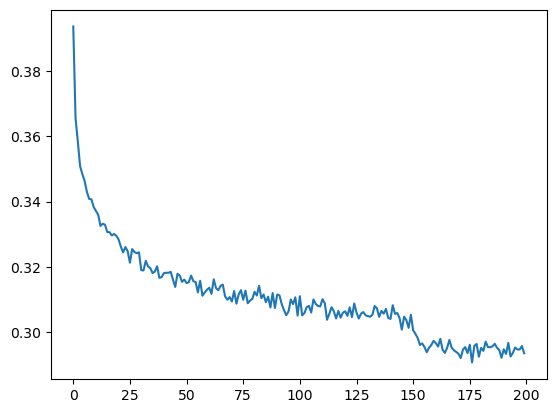

In [ ]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [ ]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9392633438110352
val 2.02504563331604


In [ ]:
for _ in range(20):
    out=[]
    context = [0]*block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:]+[ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join([itos[i] for i in out]))

mchore.
garan.
ta.
ramsam.
augan.
daclin.
miran.
adisha.
isa.
gailette.
taliya.
vayton.
emianna.
papri.
reis.
yapi.
ismayani.
dessey.
evianich.
haddie.


## Bug in BatchNorm

It's taking the mean of the first dimension this is not what we want now since we have three dimensional items going in.

In [ ]:
e = torch.randn(32,4,68)
emean = e.mean(0,keepdim=True)
evar = e.var(0,keepdim=True)
ehat = (e - emean)/torch.sqrt(evar + 1e-5)
print(emean.shape, evar.shape, ehat.shape)

torch.Size([1, 4, 68]) torch.Size([1, 4, 68]) torch.Size([32, 4, 68])


What we want is just 68 numbers for the mean and variance ( one value of mean and one for the variance for each channel). Thus our stats are only coming from 32 numbers whereas we want them to come from 32 times 4 numbers.

With broadcasting the shapes work out but the effect is not what we want.
So we need to do like so:

In [ ]:
emean = e.mean((0,1),keepdim=True)
evar = e.var((0,1),keepdim=True)
ehat = (e - emean)/torch.sqrt(evar + 1e-5)
print(emean.shape, evar.shape, ehat.shape)

torch.Size([1, 1, 68]) torch.Size([1, 1, 68]) torch.Size([32, 4, 68])


In [ ]:
class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
  
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
    
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
  
    def parameters(self):
        return [self.gamma, self.beta]

We depart from the API of PyTorch for Batchnorm which expects inputs as either (N,C) or (N,C,L) for us it will be (N,C) or (N,L,C). 

N is batchsize, C= number of features or channels, L is sequence length.

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 68 # the number of neurons in the hidden layer of the MLP

model = Sequential([Embedding(vocab_size, n_embd),
                    FlattenConsecutive(2),Linear(n_embd*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
                    FlattenConsecutive(2),Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
                    FlattenConsecutive(2),Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),                    
                    Linear(n_hidden, vocab_size)
                    ]
                   )

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # last layer make less confident at initialization

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

22397


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
#     break

      0/ 200000: 3.3042
  10000/ 200000: 1.8714
  20000/ 200000: 2.2080
  30000/ 200000: 2.4897
  40000/ 200000: 1.9405
  50000/ 200000: 1.7345
  60000/ 200000: 2.2309
  70000/ 200000: 2.4927
  80000/ 200000: 2.2003
  90000/ 200000: 1.5394
 100000/ 200000: 2.2238
 110000/ 200000: 1.7608
 120000/ 200000: 1.9861
 130000/ 200000: 2.1454
 140000/ 200000: 1.9057
 150000/ 200000: 2.0836
 160000/ 200000: 1.8067
 170000/ 200000: 1.7575
 180000/ 200000: 1.9857
 190000/ 200000: 1.6863


In [ ]:
for layer in model.layers:
    print(layer.__class__.__name__,':',tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


[<matplotlib.lines.Line2D>]

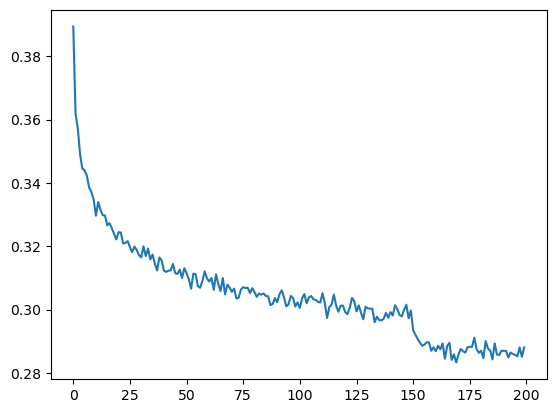

In [ ]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [ ]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.917731523513794
val 2.0245659351348877


In [ ]:
for _ in range(20):
    out=[]
    context = [0]*block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:]+[ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join([itos[i] for i in out]))

ericopal.
aiden.
jaianna.
kanah.
analimio.
adhia.
elanly.
gengi.
kaisham.
roselyd.
yuri.
nachellee.
norayany.
bosti.
salvi.
keerza.
kadi.
brigg.
keyonnord.
mattit.


## Scaling up Wavenet

In [ ]:
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP

model = Sequential([Embedding(vocab_size, n_embd),
                    FlattenConsecutive(2),Linear(n_embd*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
                    FlattenConsecutive(2),Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
                    FlattenConsecutive(2),Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),                    
                    Linear(n_hidden, vocab_size)
                    ]
                   )

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # last layer make less confident at initialization

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

76579


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
#     break

      0/ 200000: 3.2992
  10000/ 200000: 1.8959
  20000/ 200000: 2.0079
  30000/ 200000: 1.7454
  40000/ 200000: 2.4847
  50000/ 200000: 1.8896
  60000/ 200000: 1.8285
  70000/ 200000: 1.3920
  80000/ 200000: 2.2206
  90000/ 200000: 1.7741
 100000/ 200000: 1.8223
 110000/ 200000: 1.8102
 120000/ 200000: 1.8542
 130000/ 200000: 1.8778
 140000/ 200000: 1.5735
 150000/ 200000: 1.6645
 160000/ 200000: 2.0889
 170000/ 200000: 2.3077
 180000/ 200000: 1.8694
 190000/ 200000: 1.8156


In [ ]:
for layer in model.layers:
    print(layer.__class__.__name__,':',tuple(layer.out.shape))

Embedding : (32, 8, 24)
FlattenConsecutive : (32, 4, 48)
Linear : (32, 4, 128)
BatchNorm1d : (32, 4, 128)
Tanh : (32, 4, 128)
FlattenConsecutive : (32, 2, 256)
Linear : (32, 2, 128)
BatchNorm1d : (32, 2, 128)
Tanh : (32, 2, 128)
FlattenConsecutive : (32, 256)
Linear : (32, 128)
BatchNorm1d : (32, 128)
Tanh : (32, 128)
Linear : (32, 27)


In [ ]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7691593170166016
val 1.994916319847107


In [ ]:
for _ in range(20):
    out=[]
    context = [0]*block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:]+[ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join([itos[i] for i in out]))

elijah.
dawous.
kimo.
emmy.
jeshun.
lynn.
uller.
melahni.
shinhaan.
halsan.
raslyn.
kent.
jaighna.
neila.
jacinthyon.
bez.
anaiah.
dray.
ayla.
maesan.


## Experimental harness

There is a bump in performance (we cross over the 2 threshold) but now experiments are taking longer. We are in the darkness about the correct setting of the hyperparameters (learning rate etc). 

### Next time:
Why convolutions? Brief preview/hint

In [ ]:
for x,y in zip(Xtr[7:15], Ytr[7:15]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .


In [ ]:
# forward a single example:
logits = model(Xtr[[7]])
logits.shape

torch.Size([1, 27])

In [ ]:
# forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
    logits[i] = model(Xtr[[7+i]])
logits.shape

torch.Size([8, 27])

In [ ]:
# convolution is a "for loop"
# allows us to forward Linear layers efficiently over space

In [ ]:
# Fin: 56m21s